# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [2]:
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.layers import TimeDistributed,Conv2D, MaxPooling2D,LSTM
# from tensorflow.keras.layers.convolutional import 
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
import cv2

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# Intializing the parameters
curr_dt_time = datetime.datetime.now()

path = "/home/datasets/Project_data/"
train_doc = np.random.permutation(open(path + 'train.csv').readlines())
val_doc = np.random.permutation(open(path + 'val.csv').readlines())
#train_path = 'Project_data'+'/'+ 'train'
#val_path =  'Project_data'+'/'+ 'val'

train_path = path + 'train'+'/'
val_path =  path + 'val'+'/'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
batch_size =30 #experiment with the batch size

# training sequences = 663
# validation sequences = 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [6]:
class Init_modelBuilder_params():
    
    def init_imageparams(self,image_height=100,image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
        
    def init_hyperparams(self,frames_to_sample=30,batch_size=20,no_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.no_epochs = no_epochs
        
        
    def generator(self,source_path, folder_list):
        #print( 'Source path = ', source_path, '; batch size =', batch_size)
        
        #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            
            for batch in range(num_batches):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx)
                yield batch_data, batch_labels
                
            balance_len = len(t)%batch_size
            
            if (balance_len !=0):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx,balance_len)
                yield batch_data, batch_labels
                
    
    def generator_extended(self,source_path,t,batch,batch_size,img_idx,balance_len=0):
        
        len_seq = balance_len if (balance_len!=0) else batch_size
        
        batch_data = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((len_seq,5))
        # batch_labels is the one hot representation of the output
        
        for folder in range(len_seq): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image_resize = resize(image,(self.image_height,self.image_width,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image_resize[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image_resize[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image_resize[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        return(batch_data, batch_labels)
    
        
    def model_train(self, model):
        
        train_generator = self.generator(train_path, train_doc)
        val_generator = self.generator(val_path, val_doc)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        # write the REducelronplateau code here
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%self.batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1


        temp_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.no_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
        return temp_model

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

## Plotting Model History

In [7]:
# function to plot the training/validation accuracies and losses.
import matplotlib.pyplot as plt

def plot_model_history(history):
    with plt.style.context("bmh"):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
        axes[0].plot(history.history['loss'])   
        axes[0].plot(history.history['val_loss'])
        axes[0].legend(['loss','val_loss'])

        axes[1].plot(history.history['categorical_accuracy'])   
        axes[1].plot(history.history['val_categorical_accuracy'])
        axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [8]:
class Model1(Init_modelBuilder_params):
    
    def model1(self):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))
        
        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Now that you have written the model, the next step is to compile the model. When you print the summary of the model, you'll see the total number of parameters you have to train.

Let us create the train_generator and the val_generator which will be used in .fit_generator.

The steps_per_epoch and validation_steps are used by fit_generator to decide the number of next() calls it need to make.

## Experimenting with Image resolution, number of frames to use and batch_size

Lets see the impact of image resolution, number of frames and batch size on model training time

**Note:** we will train the models for only 2 epocs as we only want to see how above params affect training time

### Initial Parmas
Parmas: image_height=120,image_width=120,frames_to_sample=30,batch_size=40,no_epochs=2

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_104 (Conv3D)          (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_104 (Activation)  (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_155 (Bat (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_84 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_105 (Conv3D)          (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_105 (Activation)  (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_156 (Bat (None, 15, 60, 60, 32)  

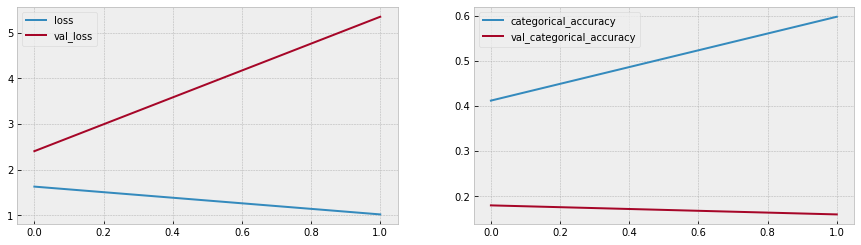

In [62]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=40,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Total Time by basic Model: 15min 41s**

### Reducing image size
Setting image size to 50 x 50

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_4 (Conv3D)            (None, 30, 50, 50, 16)    1312      
_________________________________________________________________
activation_4 (Activation)    (None, 30, 50, 50, 16)    0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 50, 50, 16)    64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 15, 25, 25, 16)    0         
_________________________________________________________________
conv3d_5 (Conv3D)            (None, 15, 25, 25, 32)    4128      
_________________________________________________________________
activation_5 (Activation)    (None, 15, 25, 25, 32)    0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 15, 25, 25, 32)   

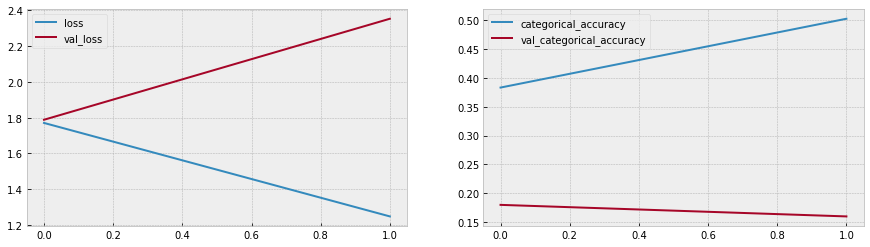

In [9]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=50,image_width=50)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=40,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Total Time by basic Model: 16min 15s**

### Reducing number of frames
Setting number of frames to 20

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 60, 60, 32)    1

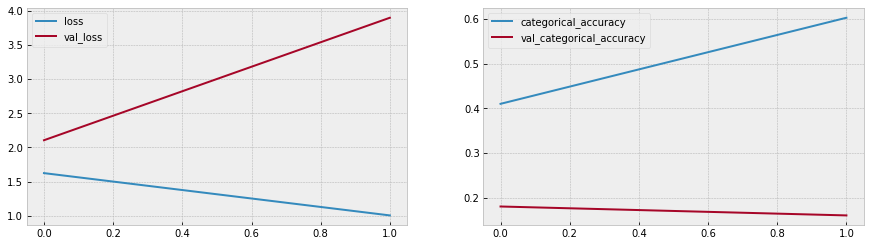

In [9]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=20,batch_size=40,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Total Time by basic Model: 10min 27s**

### Increasing batch size to 50

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_12 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_13 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 15, 60, 60, 32)   

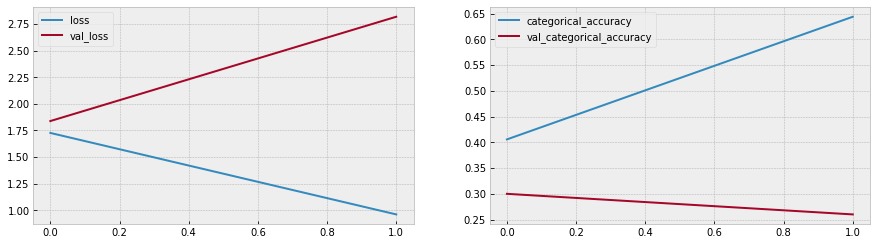

In [11]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=50,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Total Time by basic Model: 15min 34s**

### Conclusion
- Reducing image size significantly reduces the training time
- Reducing number of frames significcantly reduces the training time
- Incresing the batch size increases training time

**Initial Model**
 - params tainable: 899,941, accuracy val: 0.16, time: 15min 41s
    
**Model with image size reduced**
 - params tainable: 244,581, accuracy val: 0.16, time: 16min 15s
    
**Model with number of frames reduced**
 - params tainable: 899,941, accuracy val: 0.16, time: 10min 27s
    
**Model with increased batch size**
- params tainable: 899,941, accuracy val: 0.14, time: 15min 34s

## Finding Max Batch size we can use for image size 120 x 120
We have already tried till batch size of 50, so lets start with 60

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_17 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 15, 60, 60, 32)   

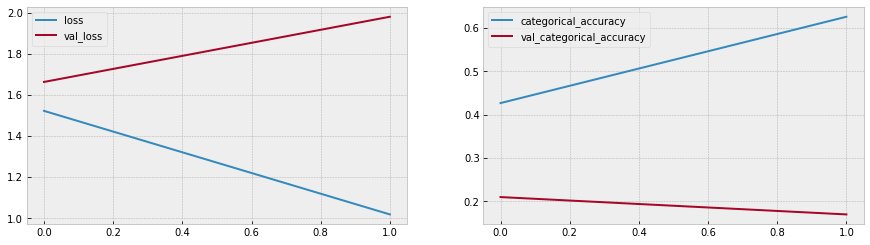

In [12]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=60,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Observation:** Batch size of 60 is too big as we GPU error **in colab** which we tried first.
So lets try with batch size of 55

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_21 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 15, 60, 60, 32)   

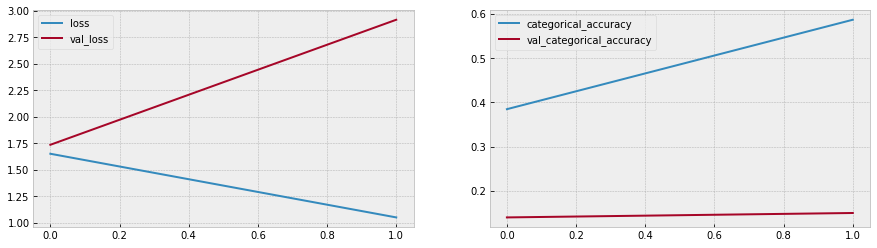

In [13]:
%%time
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=55,no_epochs=2)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)
plot_model_history(history_conv_3d1_model)

**Observation:** So batch size of 55 seems appropriate to go ahead with building our model 
******************
******************
******************

## Model 0

starting with an intital basic model

Parmas: image_height=120,image_width=120,frames_to_sample=30,batch_size=55,no_epochs=20

In [14]:
conv_3d1 = Model1()
conv_3d1.init_imageparams(image_height=120,image_width=120)
conv_3d1.init_hyperparams(frames_to_sample=30,batch_size=55,no_epochs=20)
conv_3d1_model = conv_3d1.model1()
conv_3d1_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_24 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_24 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_25 (Conv3D)           (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_25 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_37 (Batc (None, 15, 60, 60, 32)   

In [15]:
%%time
history_conv_3d1_model = conv_3d1.model_train(conv_3d1_model)

Epoch 1/20
13/13 [==============================] - ETA: 0s - loss: 1.5434 - categorical_accuracy: 0.4057 
Epoch 00001: saving model to model_init_2022-03-2812_33_21.639516/model-00001-1.54341-0.40573-2.27792-0.13000.h5
13/13 [==============================] - 159s 12s/step - loss: 1.5434 - categorical_accuracy: 0.4057 - val_loss: 2.2779 - val_categorical_accuracy: 0.1300
Epoch 2/20
13/13 [==============================] - ETA: 0s - loss: 1.0141 - categorical_accuracy: 0.5958
Epoch 00002: saving model to model_init_2022-03-2812_33_21.639516/model-00002-1.01415-0.59578-3.77886-0.20000.h5
13/13 [==============================] - 152s 12s/step - loss: 1.0141 - categorical_accuracy: 0.5958 - val_loss: 3.7789 - val_categorical_accuracy: 0.2000
Epoch 3/20
13/13 [==============================] - ETA: 0s - loss: 0.8766 - categorical_accuracy: 0.6591
Epoch 00003: saving model to model_init_2022-03-2812_33_21.639516/model-00003-0.87658-0.65913-5.30101-0.11000.h5
13/13 [=========================

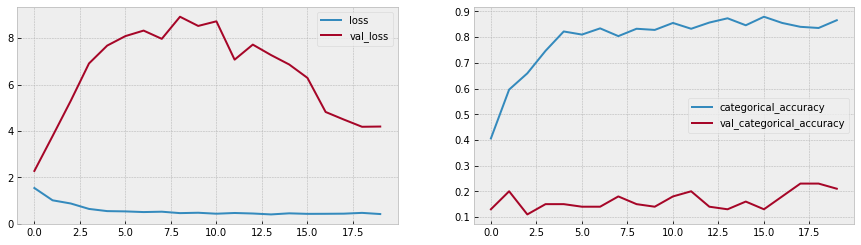

In [16]:
plot_model_history(history_conv_3d1_model)

**Observation:** We are getting a validation accuracy of 19.00% compared to tarining accuracy of 88.84%
- Total number of parameters are 900,805
- We are having low accuracy on valadation and it means its overfitting.
- Lets try **increasing** the number of parmas and see what happens

## Model 1


In [17]:
class Model2(Init_modelBuilder_params):
    
    def model2(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Parmas:**
- image_height=120 
- image_width=120 
- frames_to_sample=30
- batch_size=55
- no_epochs=20

In [18]:
conv_3d2 = Model2()
conv_3d2.init_imageparams(image_height=120,image_width=120)
conv_3d2.init_hyperparams(frames_to_sample=30,batch_size=55,no_epochs=15)
conv_3d2_model = conv_3d2.model2(dense_neurons=256, dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_28 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_28 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_42 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_28 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_29 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_29 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_43 (Batc (None, 15, 60, 60, 32)   

In [19]:
%%time
history_conv_3d2_model = conv_3d2.model_train(conv_3d2_model)

Epoch 1/15
13/13 [==============================] - ETA: 0s - loss: 1.9421 - categorical_accuracy: 0.3906 
Epoch 00001: saving model to model_init_2022-03-2812_33_21.639516/model-00001-1.94208-0.39065-4.67322-0.29000.h5
13/13 [==============================] - 160s 12s/step - loss: 1.9421 - categorical_accuracy: 0.3906 - val_loss: 4.6732 - val_categorical_accuracy: 0.2900
Epoch 2/15
13/13 [==============================] - ETA: 0s - loss: 1.5092 - categorical_accuracy: 0.5023
Epoch 00002: saving model to model_init_2022-03-2812_33_21.639516/model-00002-1.50916-0.50226-5.01622-0.22000.h5
13/13 [==============================] - 152s 12s/step - loss: 1.5092 - categorical_accuracy: 0.5023 - val_loss: 5.0162 - val_categorical_accuracy: 0.2200
Epoch 3/15
13/13 [==============================] - ETA: 0s - loss: 1.2964 - categorical_accuracy: 0.5566
Epoch 00003: saving model to model_init_2022-03-2812_33_21.639516/model-00003-1.29638-0.55656-2.52265-0.29000.h5
13/13 [=========================

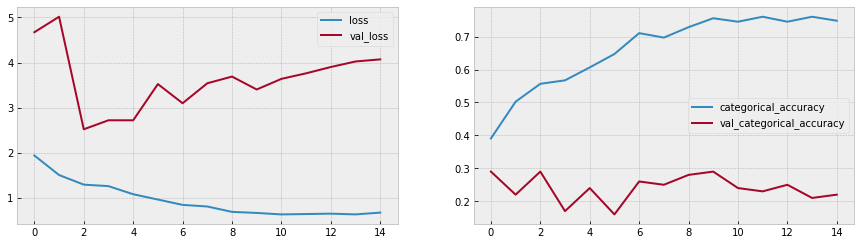

In [20]:
plot_model_history(history_conv_3d2_model)

**Observation:** We are getting a validation accuracy of 22.00% compared to tarining accuracy of 74.81%
- Total number of parameters are 1,967,813
- We are still having low accuracy on valadation and the model is overfitting.
- Lets try using Dropout


## Model 2
### Adding dropout layers


In [21]:
class Model2(Init_modelBuilder_params):
    
    def model2(self, filtersize=(3,3,3), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Parmas:**
- image_height=120 
- image_width=120 
- frames_to_sample=30
- batch_size=50
- no_epochs=15
- dropout=0.5

In [22]:
conv_3d2 = Model2()
conv_3d2.init_imageparams(image_height=120,image_width=120)
conv_3d2.init_hyperparams(frames_to_sample=30,batch_size=50,no_epochs=15)
conv_3d2_model = conv_3d2.model2(dense_neurons=256, dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_32 (Conv3D)           (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_32 (Activation)   (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_48 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_33 (Conv3D)           (None, 15, 60, 60, 32)    13856     
_________________________________________________________________
activation_33 (Activation)   (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_49 (Batc (None, 15, 60, 60, 32)   

In [23]:
%%time
history_conv_3d2_model = conv_3d2.model_train(conv_3d2_model)

Epoch 1/15
14/14 [==============================] - ETA: 0s - loss: 1.9344 - categorical_accuracy: 0.3846 
Epoch 00001: saving model to model_init_2022-03-2812_33_21.639516/model-00001-1.93439-0.38462-2.18687-0.21000.h5
14/14 [==============================] - 175s 12s/step - loss: 1.9344 - categorical_accuracy: 0.3846 - val_loss: 2.1869 - val_categorical_accuracy: 0.2100
Epoch 2/15
14/14 [==============================] - ETA: 0s - loss: 1.1431 - categorical_accuracy: 0.5837 
Epoch 00002: saving model to model_init_2022-03-2812_33_21.639516/model-00002-1.14308-0.58371-3.58809-0.22000.h5
14/14 [==============================] - 176s 13s/step - loss: 1.1431 - categorical_accuracy: 0.5837 - val_loss: 3.5881 - val_categorical_accuracy: 0.2200
Epoch 3/15
14/14 [==============================] - ETA: 0s - loss: 0.8774 - categorical_accuracy: 0.6878
Epoch 00003: saving model to model_init_2022-03-2812_33_21.639516/model-00003-0.87736-0.68778-5.45743-0.21000.h5
14/14 [========================

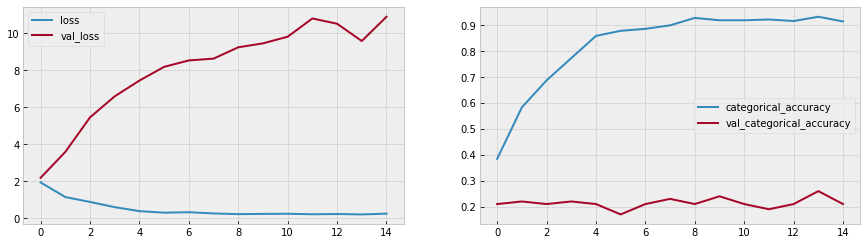

In [24]:
plot_model_history(history_conv_3d2_model)

### Observation
- We are getting a validation accuracy of 21% compared to tarining accuracy of 92.91%
- Total number of trainable parameters are 1,967,813
- There is nothing much change in performance.
- Lets try changing the filter size and Frame.

- See if it improves the model performace

## Model 3
Changing the filter to (2,2,2)

In [25]:
class Model2(Init_modelBuilder_params):
    
    def model2(self, filtersize=(2,2,2), dense_neurons=64, dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

**Parmas:**
- image_height=120
- image_width=120
- frames_to_sample=20
- batch_size=30
- no_epochs=25
- dropout=0.5

In [26]:
%%time
conv_3d5 = Model2()
conv_3d5.init_imageparams(image_height=120,image_width=120)
conv_3d5.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d5_model = conv_3d5.model2(dense_neurons=256, dropout=0.5)
conv_3d5_model.summary()
history_conv_3d5_model = conv_3d5.model_train(conv_3d5_model)


Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 20, 120, 120, 16)  400       
_________________________________________________________________
activation_36 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 10, 60, 60, 32)    4128      
_________________________________________________________________
activation_37 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 10, 60, 60, 32)   

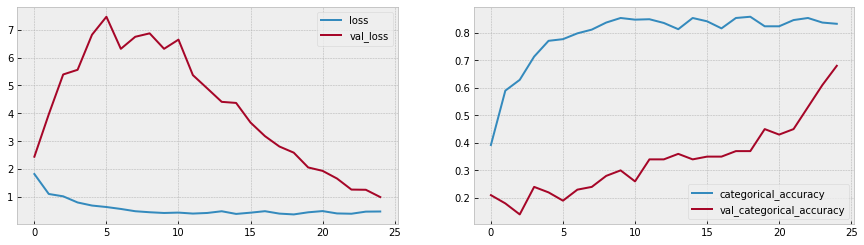

In [27]:
plot_model_history(history_conv_3d5_model)

### Observation 

- We are getting a validation accuracy of 68% compared to tarining accuracy of 83.26% 
- Total number of trainable parameters are 1,761,109.
- So by reducing the initial filter size we can see that the number of parameters have gone down
- We also observe a good increase in model's overall accuracy

Lets try **adding more layers** to see how the model performace affected

## Model 4
Addition of Layers

In [28]:
class ModelConv3D2(Init_modelBuilder_params):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
    
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_40 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_40 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_60 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_41 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_41 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_61 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_40 (MaxPooling (None, 10, 60, 60, 16)  

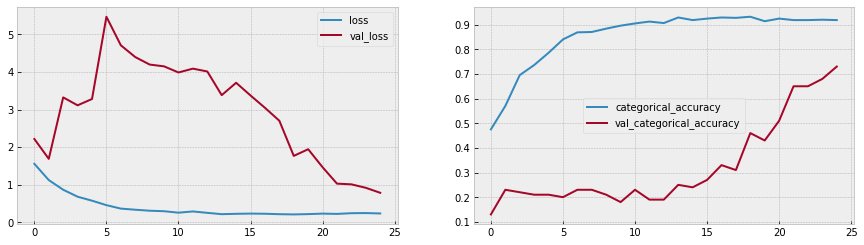

In [29]:
%%time
conv_3d4 = ModelConv3D2()
conv_3d4.init_imageparams(image_height=120,image_width=120)
conv_3d4.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d4_model = conv_3d4.model_det(filter_size=(3,3,3),dense_neurons=256,drop_out=0.25)
conv_3d4_model.summary()
history_conv_3d4_model = conv_3d4.model_train(conv_3d4_model)
plot_model_history(history_conv_3d4_model)

### Observation 
- We are getting a validation accuracy of 73% compared to tarining accuracy of 91.86% 
- Total number of trainable parameters are 2,556,533.
- So by adding more layers we can see that the number of parameters have increased a lot
- We also observe that the model's overall accuracy has incresed.

Lets try dropping some connections to see if it improves the model performace

## Model 5
Adding dropout at convolution layers

In [30]:
class ModelConv3D3(Init_modelBuilder_params):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out)) # here
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
    
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_70 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_49 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_71 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_44 (MaxPooling (None, 10, 60, 60, 16)  

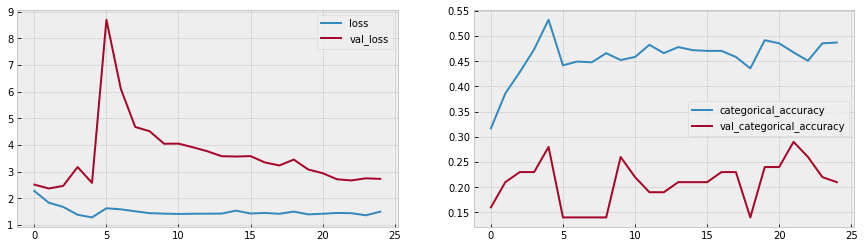

In [31]:
%%time
conv_3d5 = ModelConv3D3()
conv_3d5.init_imageparams(image_height=120,image_width=120)
conv_3d5.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d5_model = conv_3d5.model_det(filter_size=(3,3,3),dense_neurons=256,drop_out=0.5)
conv_3d5_model.summary()
history_conv_3d5_model = conv_3d5.model_train(conv_3d5_model)
plot_model_history(history_conv_3d5_model)

## Observation 
- We are getting a validation accuracy of 21% compared to tarining accuracy of 48.72% 
- Total number of trainable parameters are 2,556,533.
- Here we observe a significant drop in model performace

Issue could be dropout layers... We kept as 50% which could be too high and will see to keep it as 25%.
Dropout=0.25

## Model 5.1:
- Reducing the dropout to 25%

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_56 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_56 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_80 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
conv3d_57 (Conv3D)           (None, 20, 120, 120, 16)  6928      
_________________________________________________________________
activation_57 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_81 (Batc (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 10, 60, 60, 16)  

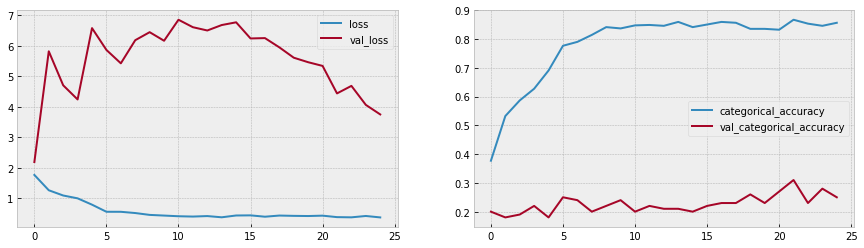

In [32]:
%%time
conv_3d5 = ModelConv3D3()
conv_3d5.init_imageparams(image_height=120,image_width=120)
conv_3d5.init_hyperparams(frames_to_sample=20,batch_size=30,no_epochs=25)
conv_3d5_model = conv_3d5.model_det(filter_size=(3,3,3),dense_neurons=256,drop_out=0.25)
conv_3d5_model.summary()
history_conv_3d5_model = conv_3d5.model_train(conv_3d5_model)
plot_model_history(history_conv_3d5_model)

## Observation 
- We are getting a validation accuracy of 25% compared to tarining accuracy of 85.67% 
- Total number of trainable parameters are 2,556,533.
- Here we observe a significant improve in training accuracy and but same validation accuracy.
- Reason can be overfitting.


Issue could be the large number of parameters and the number of layers adding to the complexity. So we want to reduce the number of params now

# Model 6
All models experimental models above have more than 1 million parameters. Let's try to reduce the model size and see the performance

In [33]:
class ModelConv3D4(Init_modelBuilder_params):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**
- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=20
- dropout=0.25
- dense_neurons=128

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_64 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_64 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_90 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_65 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_65 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_91 (Batc (None, 8, 60, 60, 32)   

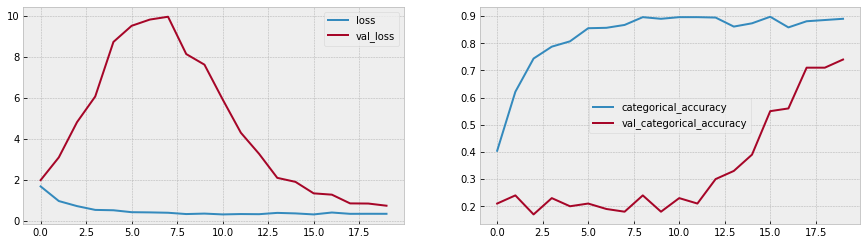

In [34]:
%%time
conv_3d6 = ModelConv3D4()
conv_3d6.init_imageparams(image_height=120,image_width=120)
conv_3d6.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=20)
conv_3d6_model = conv_3d6.model_det(dense_neurons=128,drop_out=0.25)
conv_3d6_model.summary()
history_conv_3d6_model = conv_3d6.model_train(conv_3d6_model)
plot_model_history(history_conv_3d6_model)


### Observation 
- We are getting a validation accuracy of 74% compared to tarining accuracy of 88.99% 
- Total number of trainable parameters are 908,645 which is almost half of our last model.
- Here we observe a major increase in model performance but it’s **clearly overfitting.**

Lets see if we can get a better result by futher reducing the number of parameters

## Model 7
Reducing the number of parameters again

In [35]:
class ModelConv3D4(Init_modelBuilder_params):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**
- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=20
- dropout=0.25
- dense_neurons=64

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_68 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_68 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_96 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_56 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_69 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_69 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_97 (Batc (None, 8, 60, 60, 32)   

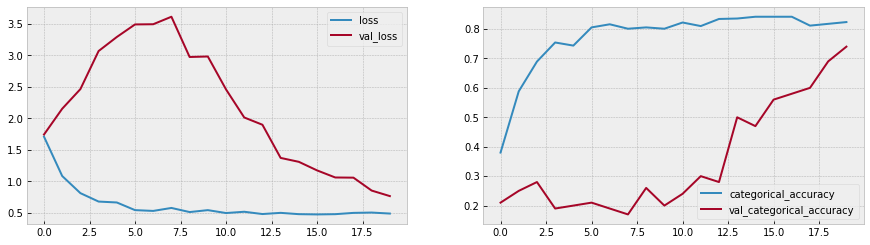

In [36]:
%%time
conv_3d7 = ModelConv3D4()
conv_3d7.init_imageparams(image_height=120,image_width=120)
conv_3d7.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=20)
conv_3d7_model = conv_3d7.model_det(dense_neurons=64,drop_out=0.25)
conv_3d7_model.summary()
history_conv_3d7_model = conv_3d7.model_train(conv_3d7_model)
plot_model_history(history_conv_3d7_model)


### Observation 
- We are getting a validation accuracy of 74% compared to tarining accuracy of 82.35% 
- Total number of parameters are 494,981 which is almost half of our last model.
- We can see the model is performing well but accuracy is still low.
- **Even from model 0-6 all are overfitting**

Lets move ahead and try a CNN (2D conv) + RNN (LSTM) model 

## Model 8
CNN- LSTM Model

In [8]:
class RNNLstm(Init_modelBuilder_params):
    
    def model_det(self,lstm_cells=64,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation = 'relu'),
                                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                  
        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                        
        model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                          
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(lstm_cells))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(self.num_classes,activation='softmax'))
                  
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**
- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=25
- dropout=0.25
- dense_neurons=128
- lstm_cells=128

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 16, 30, 30, 64)    1

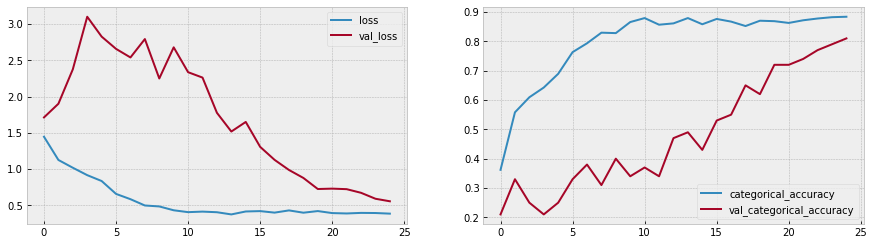

In [9]:
%%time
lstm_1 = RNNLstm()
lstm_1.init_imageparams(image_height=120,image_width=120)
lstm_1.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
lstm_1_model = lstm_1.model_det(lstm_cells=128,dense_neurons=128,drop_out=0.25)
lstm_1_model.summary()
history_lstm_1_model = lstm_1.model_train(lstm_1_model)
plot_model_history(history_lstm_1_model)


### Observation 
- We are getting a validation accuracy of 81% compared to tarining accuracy of 88.39% 
- Total number of trainable parameters are 1,656,453
- We can see with LSTM, we are getting good accuracy. <br>
Lets try with **GRU.**

## Model 8.1
CNN- GRU Model

In [10]:
class RNN_GRU(Init_modelBuilder_params):
    
    def model_det(self,GRU_cells=64,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding='same', activation = 'relu'),
                                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
        model.add(TimeDistributed(Conv2D(32, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                  
        model.add(TimeDistributed(Conv2D(64, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                  
                        
        model.add(TimeDistributed(Conv2D(256, (3,3), padding='same', activation = 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
                          
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(GRU_cells))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
                  
        model.add(Dense(self.num_classes,activation='softmax'))
                  
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 16, 30, 30, 64)   

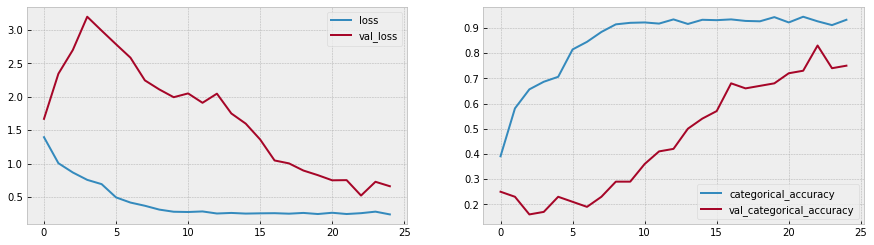

In [11]:
%%time
GRU_1 = RNN_GRU()
GRU_1.init_imageparams(image_height=120,image_width=120)
GRU_1.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
GRU_1_model = GRU_1.model_det(GRU_cells=128,dense_neurons=128,drop_out=0.25)
GRU_1_model.summary()
history_GRU_1_model = GRU_1.model_train(GRU_1_model)
plot_model_history(history_GRU_1_model)


### Observation 
- We are getting a validation accuracy of 75% compared to tarining accuracy of 93.21% 
- Total number of trainable parameters are 1,346,405
- LSTM was performing much better than GRU. <BR>

### lets see if we can inprove it futher by using **data augmentaion techniques**

******
******
******
******

# Let's apply some data augmentation & check the model performance.

In [8]:
class Model_params_Augmentdata():
    
    def init_imageparams(self,image_height=100,image_width=100):
        self.image_height = image_height
        self.image_width = image_width
        self.channels = 3
        self.num_classes = 5
        self.total_frames = 30
        
    def init_hyperparams(self,frames_to_sample=30,batch_size=20,no_epochs=20):
        self.frames_to_sample = frames_to_sample
        self.batch_size = batch_size
        self.no_epochs = no_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
#         print( 'Source path = ', source_path, '; batch size =', batch_size)
        
        #create a list of image numbers you want to use for a particular video
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size = self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
            
            for batch in range(num_batches):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels
                
            balance_len = len(t)%batch_size
            
            if (balance_len !=0):
                batch_data, batch_labels = self.generator_extended(source_path,t,batch,batch_size,img_idx,augment,balance_len)
                yield batch_data, batch_labels
                
    
    def generator_extended(self,source_path,t,batch,batch_size,img_idx,augment,balance_len=0):
        
        len_seq = balance_len if (balance_len!=0) else batch_size
        
        batch_data = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        batch_data = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((len_seq,5))
        # batch_labels is the one hot representation of the output
        if (augment): batch_data_aug = np.zeros((len_seq,len(img_idx),self.image_height,self.image_width,self.channels))
        
        for folder in range(len_seq): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                image_resize = resize(image,(self.image_height,self.image_width,3))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    #normalise and feed in the image
                batch_data[folder,idx,:,:,0] = (image_resize[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resize[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resize[:,:,2])/255
                    
                if (augment):
                        
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    image_resized=resize(cropped,(self.image_height,self.image_width,3))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
      
                    
                        
                    #normalise and feed in the image
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                        
                    
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
                
        if (augment):
            
            batch_data = np.concatenate([batch_data,batch_data_aug])
            batch_labels = np.concatenate([batch_labels,batch_labels])
                
        return(batch_data, batch_labels)
    
        
    def model_train(self ,model,augment_data=False):
        
        train_generator = self.generator(train_path, train_doc,augment= augment_data)
        val_generator = self.generator(val_path, val_doc)

        model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'

        if not os.path.exists(model_name):
            os.mkdir(model_name)

        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

        # write the REducelronplateau code here
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.1,verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (num_train_sequences//self.batch_size) + 1

        if (num_val_sequences%self.batch_size) == 0:
            validation_steps = int(num_val_sequences/self.batch_size)
        else:
            validation_steps = (num_val_sequences//self.batch_size) + 1


        temp_model = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.no_epochs, verbose=1, 
                        callbacks=callbacks_list, validation_data=val_generator, 
                        validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
    
        return temp_model

## Model 9
adding data augmentation

In [40]:
class ModelConv3D_Aug1(Model_params_Augmentdata):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**
- image_height=120
- image_width=120
- frames_to_sample=20
- batch_size=20
- no_epochs=25
- dropout=0.5
- dense_neurons=256


Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_72 (Conv3D)           (None, 20, 120, 120, 16)  1312      
_________________________________________________________________
activation_72 (Activation)   (None, 20, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_107 (Bat (None, 20, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_60 (MaxPooling (None, 10, 60, 60, 16)    0         
_________________________________________________________________
conv3d_73 (Conv3D)           (None, 10, 60, 60, 32)    13856     
_________________________________________________________________
activation_73 (Activation)   (None, 10, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_108 (Bat (None, 10, 60, 60, 32)  

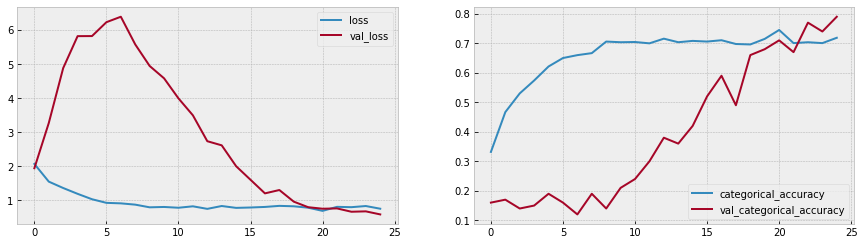

In [41]:
%%time
conv_3d_aug1 = ModelConv3D_Aug1()
conv_3d_aug1.init_imageparams(image_height=120,image_width=120)
conv_3d_aug1.init_hyperparams(frames_to_sample=20,batch_size=20,no_epochs=25)
conv_3d_aug1_model = conv_3d_aug1.model_det(dense_neurons=256,drop_out=0.5)
conv_3d_aug1_model.summary()
history_conv_3d_aug1_model = conv_3d_aug1.model_train(conv_3d_aug1_model,augment_data=True)
plot_model_history(history_conv_3d_aug1_model)


### Observation 
- We are getting a validation accuracy of 79% compared to tarining accuracy of 71.87% 
- Total number of trainable parameters are 1,966,309.
- We see that the validation accuracy has improved alot and the training accuracy has dropped slightly compare to model 0.

Lets see if we can improve the model with some basic simplifications

## Model 10
Incrasing batch size and decrsing filter size
**Parmas:**
- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=30
- no_epochs=25
- dropout=0.5
- dense_neurons=256
- filter_size=(2,2,2)


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_76 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_76 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_113 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_64 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_77 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_77 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_114 (Bat (None, 8, 60, 60, 32)   

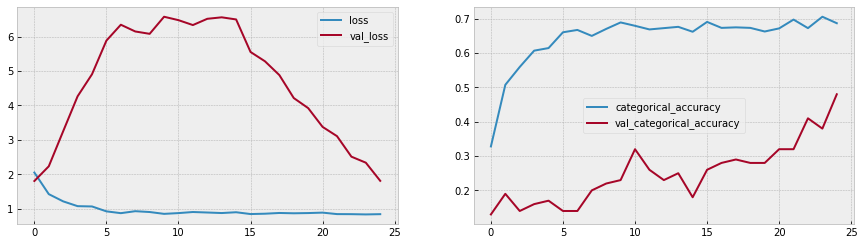

In [42]:
%%time
conv_3d_aug1 = ModelConv3D_Aug1()
conv_3d_aug1.init_imageparams(image_height=120,image_width=120)
conv_3d_aug1.init_hyperparams(frames_to_sample=16,batch_size=30,no_epochs=25)
conv_3d_aug1_model = conv_3d_aug1.model_det(filter_size=(2,2,2),dense_neurons=256,drop_out=0.5)
conv_3d_aug1_model.summary()
history_conv_3d_aug1_model = conv_3d_aug1.model_train(conv_3d_aug1_model,augment_data=True)
plot_model_history(history_conv_3d_aug1_model)


### Observation 
- We are getting a validation accuracy of 48% compared to tarining accuracy of 68.70% 
- Total number of trainable parameters are 1,761,109. Reduced slightly from previous model.
- We see that both the validation accuracy and the training accuracy have shown **decreased**

Lets see the impact of **adding more layers** to our present model

# Model 11
Adding more layers

In [64]:
class ModelConv3D_Aug2(Model_params_Augmentdata):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

**Parmas:**
- image_height=120
- image_width=120
- frames_to_sample=16
- batch_size=20
- no_epochs=25
- dropout=0.5
- dense_neurons=256


Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_108 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_108 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_161 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_109 (Conv3D)          (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_109 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_162 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_88 (MaxPooling (None, 8, 60, 60, 16)   

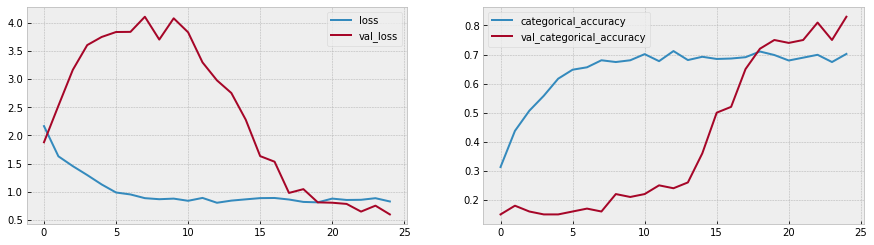

In [65]:
%%time
conv_3d_aug2 = ModelConv3D_Aug2()
conv_3d_aug2.init_imageparams(image_height=120,image_width=120)
conv_3d_aug2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
conv_3d_aug2_model = conv_3d_aug2.model_det(dense_neurons=256,drop_out=0.5)
conv_3d_aug2_model.summary()
history_conv_3d_aug2_model = conv_3d_aug2.model_train(conv_3d_aug2_model,augment_data=True)
plot_model_history(history_conv_3d_aug2_model)


### Observation 
- We are getting a validation accuracy of 83% compared to tarining accuracy of 70.21% 
- Total number of trainable parameters are 2,554,549. Major increase from previous model
- We see that both the validation accuracy and the training accuracy have shown improvement

Lets see if reducing number of trainable params with dropout helps improving the model or not

## Model 12
Adding dropouts

In [66]:
class ModelConv3D_Aug2(Model_params_Augmentdata):
    
    def model_det(self,filter_size=(3,3,3),dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16,filter_size, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        
        model.add(Conv3D(128,filter_size, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        model.add(Dropout(drop_out))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model
        

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_116 (Conv3D)          (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_116 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_171 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_117 (Conv3D)          (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_117 (Activation)  (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_172 (Bat (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_92 (MaxPooling (None, 8, 60, 60, 16)   

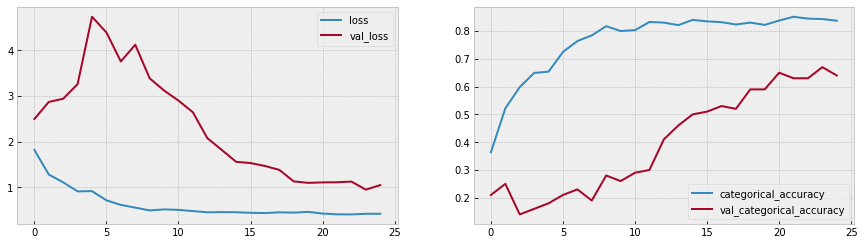

In [67]:
%%time
conv_3d_aug2 = ModelConv3D_Aug2()
conv_3d_aug2.init_imageparams(image_height=120,image_width=120)
conv_3d_aug2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
conv_3d_aug2_model = conv_3d_aug2.model_det(dense_neurons=256,drop_out=0.25)
conv_3d_aug2_model.summary()
history_conv_3d_aug2_model = conv_3d_aug2.model_train(conv_3d_aug2_model,augment_data=True)
plot_model_history(history_conv_3d_aug2_model)


### Observation 
- We are getting a validation accuracy of 78% compared to tarining accuracy of 92.76% 
- Total number of trainable parameters are 2,554,549.
- We see that both the validation accuracy has decresed but the training accuracy have shown improvement. But its overfitting.

Lets see if reducing number of network params helps improving the model or not

# Model 13
Reducing network parameters

In [17]:
class ModelConv3D_Aug3(Model_params_Augmentdata):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [18]:
%%time
conv_3d_aug3 = ModelConv3D_Aug3()
conv_3d_aug3.init_imageparams(image_height=120,image_width=120)
conv_3d_aug3.init_hyperparams(frames_to_sample=30,batch_size=20,no_epochs=25)
conv_3d_aug3_model = conv_3d_aug3.model_det(dense_neurons=128,drop_out=0.25)
conv_3d_aug3_model.summary()
history_conv_3d_aug3_model = conv_3d_aug3.model_train(conv_3d_aug3_model,augment_data=True)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 30, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 30, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 30, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_8 (MaxPooling3 (None, 15, 60, 60, 16)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 15, 60, 60, 32)    4128      
_________________________________________________________________
activation_9 (Activation)    (None, 15, 60, 60, 32)    0         
_________________________________________________________________
batch_normalization_18 (Batc (None, 15, 60, 60, 32)   

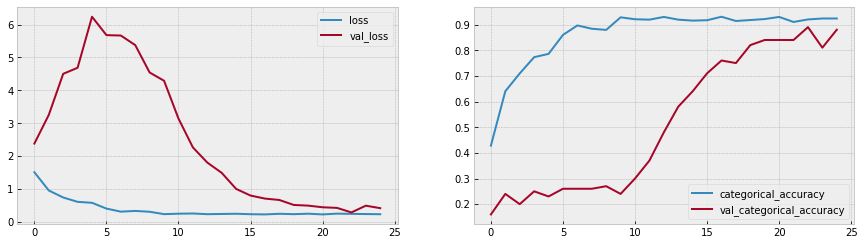

In [19]:
plot_model_history(history_conv_3d_aug3_model)

### Observation 
- We are getting a validation accuracy of 88% compared to tarining accuracy of 92.38% 
- Total number of trainable parameters are 908,645. Which is quite less than before.
- We see huge improvement in both the validation accuracy and the training accuracy.
- lets try to decrease the frame number to 16, filter to 2 and epoch to 35 and see.

## Model 13.1

In [21]:
class ModelConv3D_Aug3(Model_params_Augmentdata):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16, (2,2,2), padding='same', 
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [22]:
%%time
conv_3d_aug3 = ModelConv3D_Aug3()
conv_3d_aug3.init_imageparams(image_height=120,image_width=120)
conv_3d_aug3.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=35)
conv_3d_aug3_model = conv_3d_aug3.model_det(dense_neurons=128,drop_out=0.25)
conv_3d_aug3_model.summary()
history_conv_3d_aug3_model = conv_3d_aug3.model_train(conv_3d_aug3_model,augment_data=True)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 16, 120, 120, 16)  400       
_________________________________________________________________
activation_12 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_23 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_13 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 8, 60, 60, 32)    

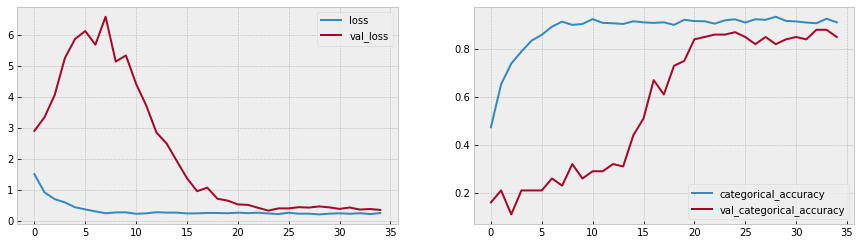

In [23]:
plot_model_history(history_conv_3d_aug3_model)

### Observation 
- We are getting a validation accuracy of 85% compared to tarining accuracy of 91.1% 
- Total number of trainable parameters are 907,733. Which is quite less than before.
- We see that both the validation accuracy and the training accuracy have shown decreased. 

Lets see if further reducing number of frame to 16 and used same model as model no 13 and keep epoch as 35

## Model 13.2

In [24]:
class ModelConv3D_Aug3(Model_params_Augmentdata):
    
    def model_det(self,dense_neurons=64,drop_out=0.25):
        
        model = Sequential()
        model.add(Conv3D(16,(3,3,3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(32,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(64,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Conv3D(128,(2,2,2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2,2,2)))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_29 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_17 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 8, 60, 60, 32)    

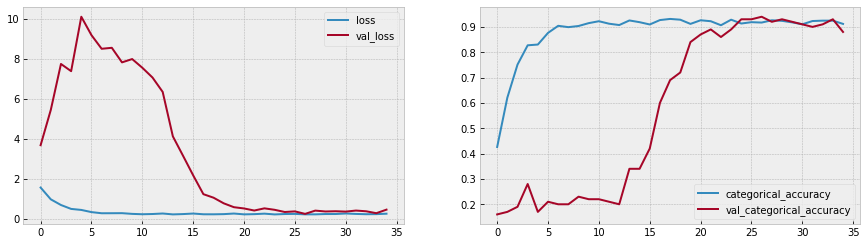

In [25]:
%%time
conv_3d_aug3 = ModelConv3D_Aug3()
conv_3d_aug3.init_imageparams(image_height=120,image_width=120)
conv_3d_aug3.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=35)
conv_3d_aug3_model = conv_3d_aug3.model_det(dense_neurons=128,drop_out=0.25)
conv_3d_aug3_model.summary()
history_conv_3d_aug3_model = conv_3d_aug3.model_train(conv_3d_aug3_model,augment_data=True)

plot_model_history(history_conv_3d_aug3_model)

### Observation 
- We are getting a validation accuracy of 94% compared to tarining accuracy of 91.70% 
- Total number of trainable parameters are 908,645. 
- We see that both the validation accuracy and the training accuracy have shown huge improvement and we have solved the overfitting.
- And as of now this is **the best model from model 0 - 13.2**

Epoch 27/35<br>
34/34 [==============================] - ETA: 0s - loss: 0.2235 - categorical_accuracy: 0.9170<br>
Epoch 00027: saving model to model_init_2022-03-3000_32_31.592439/model-00027-0.22354-0.91704-0.24704-0.94000.h5<br>
34/34 [==============================] - 145s 4s/step - loss: 0.2235 - categorical_accuracy: **0.9170** - val_loss: 0.2470 - val_categorical_accuracy: **0.9400**<br>

Lets see if further increasing the batchsize of network params helps improving the model or not.

## Model 13.3

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_20 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_20 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_35 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_20 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_21 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_21 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_36 (Batc (None, 8, 60, 60, 32)    

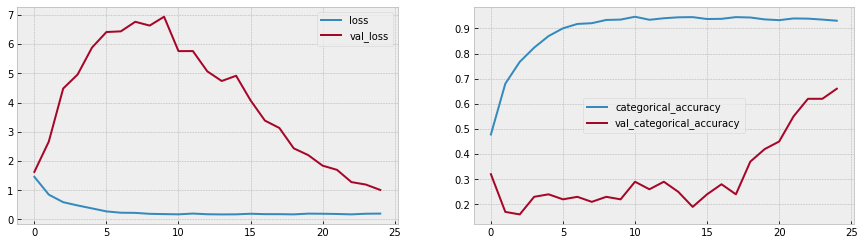

In [26]:
%%time
conv_3d_aug3 = ModelConv3D_Aug3()
conv_3d_aug3.init_imageparams(image_height=120,image_width=120)
conv_3d_aug3.init_hyperparams(frames_to_sample=16,batch_size=32,no_epochs=25)
conv_3d_aug3_model = conv_3d_aug3.model_det(dense_neurons=128,drop_out=0.25)
conv_3d_aug3_model.summary()
history_conv_3d_aug3_model = conv_3d_aug3.model_train(conv_3d_aug3_model,augment_data=True)

plot_model_history(history_conv_3d_aug3_model)

### Observation 
- We are getting a validation accuracy of 66% compared to tarining accuracy of 93.06%.
- Total number of trainable parameters are 908,645. Which is quite less than before.
- There is a decrease in performance .
Lets see if further reducing number of network params helps improving the model or not.

## Model 14
Reducing network parameters again
- dense = 64

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_16 (Conv3D)           (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_16 (Activation)   (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_16 (MaxPooling (None, 8, 60, 60, 16)     0         
_________________________________________________________________
conv3d_17 (Conv3D)           (None, 8, 60, 60, 32)     4128      
_________________________________________________________________
activation_17 (Activation)   (None, 8, 60, 60, 32)     0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 8, 60, 60, 32)    

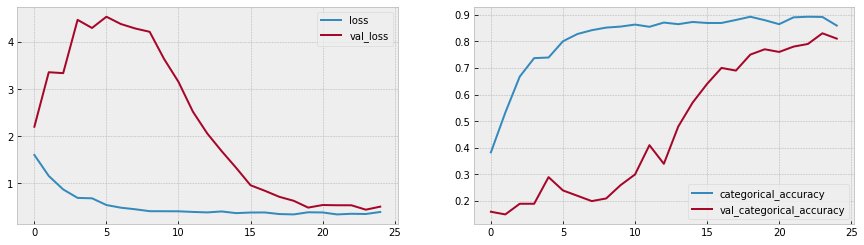

In [23]:
%%time
conv_3d_aug3 = ModelConv3D_Aug3()
conv_3d_aug3.init_imageparams(image_height=120,image_width=120)
conv_3d_aug3.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
conv_3d_aug3_model = conv_3d_aug3.model_det(dense_neurons=64,drop_out=0.25)
conv_3d_aug3_model.summary()
history_conv_3d_aug3_model = conv_3d_aug3.model_train(conv_3d_aug3_model,augment_data=True)
plot_model_history(history_conv_3d_aug3_model)


### Observation 
- We are getting a validation accuracy of 81% compared to tarining accuracy of 85.90% 
- Total number of trainable parameters are 494,245. Which is quite less than before
- We see that the validation accuracy and the training accuracy has reduced slightly

Lets try a different model like CNN (2D) + RNN (GRU) next

## Model 15
CNN with GRU

In [24]:
class RNNCNN2(Model_params_Augmentdata):
    
    def model_det(self, GRU_cells=64, dense_neurons=64, drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding = 'same', activation= 'relu'),
                                 input_shape = (self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(GRU_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [25]:
%%time
gru_2 = RNNCNN2()
gru_2.init_imageparams(image_height=120,image_width=120)
gru_2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
gru_2_model = gru_2.model_det(GRU_cells=128, dense_neurons=128, drop_out=0.25)
gru_2_model.summary()
history_gru_2_model = gru_2.model_train(gru_2_model)


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_26 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_27 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_28 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_29 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 30, 30, 64)   

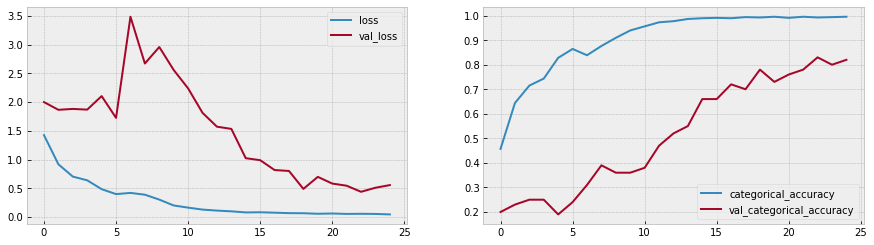

In [29]:

plot_model_history(history_gru_2_model)

**Observation:** We are getting a validation accuracy of 82.00% compared to tarining accuracy of 99.55%
- Total number of parameters are 2,557,413.
- We can clearly see its **overfitting.**
- Now lets try **LSTM.**


## Model 15.1
CNN with LSTM

In [30]:
class RNNCNN2(Model_params_Augmentdata):
    
    def model_det(self, LSTM_cells=64, dense_neurons=64, drop_out=0.25):
        
        model = Sequential()
        
        model.add(TimeDistributed(Conv2D(16, (3,3), padding = 'same', activation= 'relu'),
                                 input_shape = (self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        
        model.add(TimeDistributed(Conv2D(128, (3,3), padding = 'same', activation= 'relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2,2))))
        
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(LSTM_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes,activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        
        return model

In [31]:
%%time
lstm_2 = RNNCNN2()
lstm_2.init_imageparams(image_height=120,image_width=120)
lstm_2.init_hyperparams(frames_to_sample=16,batch_size=20,no_epochs=25)
lstm_2_model = lstm_2.model_det(LSTM_cells=128, dense_neurons=128, drop_out=0.25)
lstm_2_model.summary()
history_lstm_2_model = lstm_2.model_train(lstm_2_model)


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_39 (TimeDis (None, 16, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_40 (TimeDis (None, 16, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_41 (TimeDis (None, 16, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_42 (TimeDis (None, 16, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_43 (TimeDis (None, 16, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_44 (TimeDis (None, 16, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_45 (TimeDis (None, 16, 30, 30, 64)   

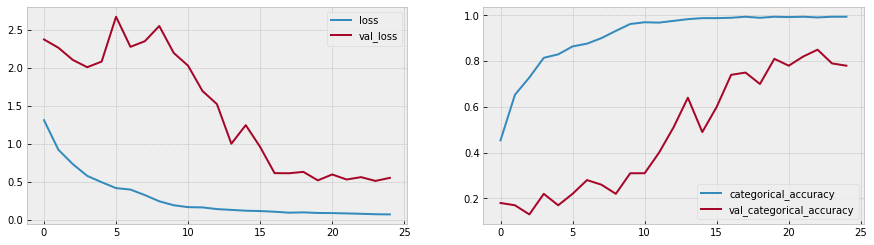

In [37]:
plot_model_history(history_lstm_2_model)

**Observation:** We are getting a validation accuracy of 78.00% compared to tarining accuracy of 99.40%
- Total number of parameters are 2,557,413.
- We can clearly see its **overfitting.**
- Now lets try **transfer learning.**


***********
***********
***********

## Let us bring in Transfer Learning 
## Model 16: with LSTM
**https://www.tensorflow.org/api_docs/python/tf/keras/applications**

In [32]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from tensorflow.keras.applications import MobileNet
transfer_learning = MobileNet(weights = 'imagenet', include_top = False)

17227776/17225924 [==============================] - 1s 0us/step


In [33]:
class RNN_CNN_TL1(Model_params_Augmentdata):
    
    def model_det(self,lstm_cells=64, dense_neurons=64, drop_out=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(transfer_learning,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(lstm_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_52 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_53 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_54 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_55 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               590336    
_________________________________________________________________
dropout_13 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)              

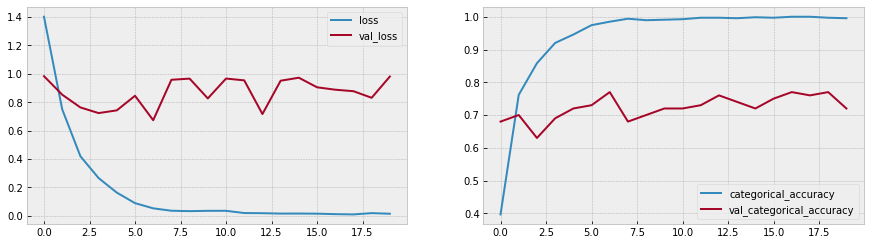

In [34]:
%%time
tranf_learning = RNN_CNN_TL1()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16,batch_size=10,no_epochs=20)
tranf_learning_model = tranf_learning.model_det(lstm_cells=128, dense_neurons=128, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model = tranf_learning.model_train(tranf_learning_model)

plot_model_history(history_tranf_learning_model)

**Observation:** We are getting a validation accuracy of 72.00% compared to tarining accuracy of 99.55%
- Total number of parameters are 3,840,453.
- We can clearly see its overfitting.
- lets try reducing the cell and dense by 50%

## Model 16.1:
- Reducing the cell and dense by 50%

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_80 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_81 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_82 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_83 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 64)                278784    
_________________________________________________________________
dropout_27 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)              

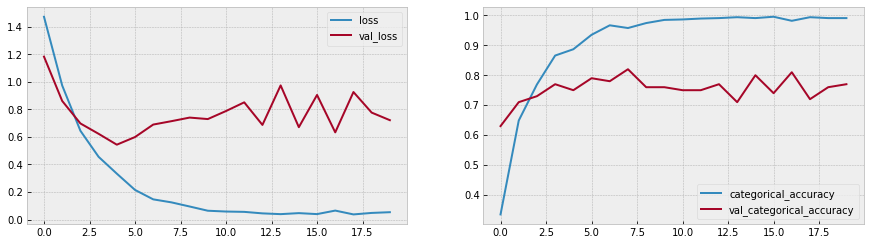

In [49]:
%%time
tranf_learning = RNN_CNN_TL1()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16,batch_size=10,no_epochs=20)
tranf_learning_model = tranf_learning.model_det(lstm_cells=64, dense_neurons=64, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model = tranf_learning.model_train(tranf_learning_model)

plot_model_history(history_tranf_learning_model)


**Observation:** We are getting a validation accuracy of 77.00% compared to tarining accuracy of 99.1%
- Total number of parameters are 3,516,229.
- We can clearly see its overfitting.
- lets try with GRU.

## Model 17
Transfer Learning with GRU and training all weights

In [38]:
transfer_learning2 = MobileNet(weights = 'imagenet', include_top = False)

class RNN_CNN_TL2(Model_params_Augmentdata):
    
    def model_det(self,gru_cells =64,dense_neurons= 64, drop_out=0.25):
        model = Sequential()
        model.add(TimeDistributed(transfer_learning,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [39]:
%%time
tranf_learning = RNN_CNN_TL2()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16, batch_size=10, no_epochs=20)

tranf_learning_model = tranf_learning.model_det(gru_cells=128, dense_neurons=128, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model1 = tranf_learning.model_train(tranf_learning_model)


Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_60 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_61 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_62 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_63 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_3 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_17 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)             

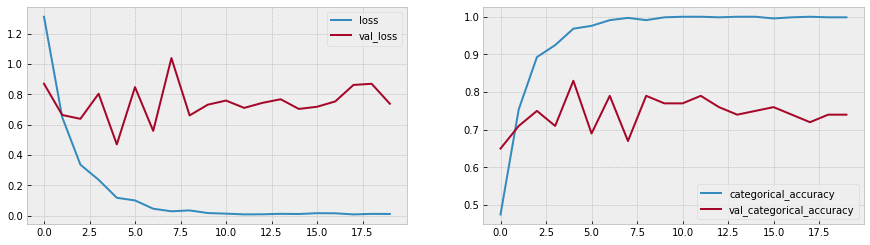

In [40]:
plot_model_history(history_tranf_learning_model1)

Observation:** We are getting a validation accuracy of 74.00% compared to tarining accuracy of 99.85%
- Total number of parameters are 3,693,253. 
- We can clearly see its overfitting.
- lets try with GRU with cell=64 and dense=64


## Model 18:
Transfer Learning with GRU with cell=64 and dense=64

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_64 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_65 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_66 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_67 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_4 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_19 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (Dense)             (None, 64)              

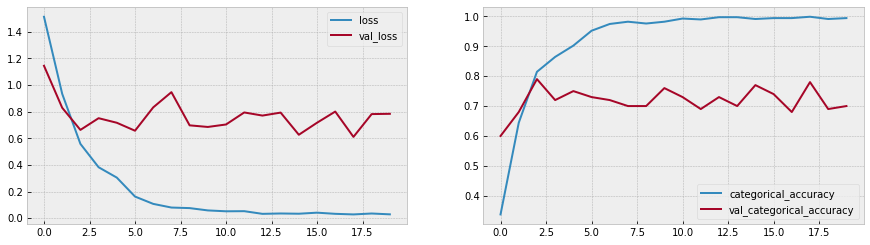

In [41]:
%%time
tranf_learning = RNN_CNN_TL2()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16,batch_size=10,no_epochs=20)
tranf_learning_model = tranf_learning.model_det(gru_cells=64, dense_neurons=64, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model2 = tranf_learning.model_train(tranf_learning_model)
plot_model_history(history_tranf_learning_model2)


Observation:** We are getting a validation accuracy of 70.00% compared to tarining accuracy of 99.40%
- Total number of parameters are 3,446,725. 
- We can clearly see its overfitting again.
- So, we dont see much improvement with recusing dense and number of cell.
- Lets try to applying it **without augmentation.**


## Model 19: 
- Without augmentation

In [46]:
transfer_learning2 = MobileNet(weights = 'imagenet', include_top = False)

class RNN_CNN_TL3(Init_modelBuilder_params):
    
    def model_det(self,gru_cells =64,dense_neurons= 64, drop_out=0.25):
        model = Sequential()
        model.add(TimeDistributed(transfer_learning,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [47]:
%%time
tranf_learning = RNN_CNN_TL3()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16, batch_size=10, no_epochs=20)

tranf_learning_model = tranf_learning.model_det(gru_cells=64, dense_neurons=64, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model1 = tranf_learning.model_train(tranf_learning_model)


Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_72 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_73 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_74 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_75 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_6 (GRU)                  (None, 64)                209280    
_________________________________________________________________
dropout_23 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 64)              

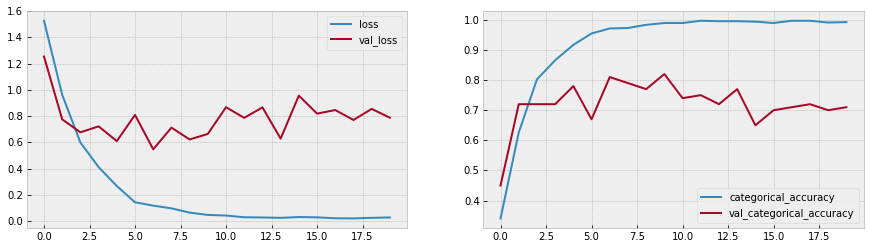

In [50]:
plot_model_history(history_tranf_learning_model1)

**Observation:** We are getting a validation accuracy of 71.00% compared to tarining accuracy of 99.25%
- Total number of parameters are 3,446,725.
- We can clearly see its overfitting again.
- So, we dont see much improvement with recusing dense and number of cell.
- Lets try to applying **EfficientNetB2.**

## Model 19: Using EfficientNetB2
- gru_cells=64
- dense_neurons=64

In [42]:
from tensorflow.keras.applications import EfficientNetB2

In [43]:
transfer_learning_model = EfficientNetB2(weights = 'imagenet', include_top = False)

31793152/31790344 [==============================] - 3s 0us/step


In [44]:

class RNN_CNN_TL2(Model_params_Augmentdata):
    
    def model_det(self, gru_cells=64, dense_neurons= 64, drop_out=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(transfer_learning_model, input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        
        for layer in model.layers:
            layer.trainable = False
            
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(2,2)))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(drop_out))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_68 (TimeDis (None, 16, 3, 3, 1408)    7768569   
_________________________________________________________________
time_distributed_69 (TimeDis (None, 16, 3, 3, 1408)    5632      
_________________________________________________________________
time_distributed_70 (TimeDis (None, 16, 1, 1, 1408)    0         
_________________________________________________________________
time_distributed_71 (TimeDis (None, 16, 1408)          0         
_________________________________________________________________
gru_5 (GRU)                  (None, 128)               590592    
_________________________________________________________________
dropout_21 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_26 (Dense)             (None, 128)             

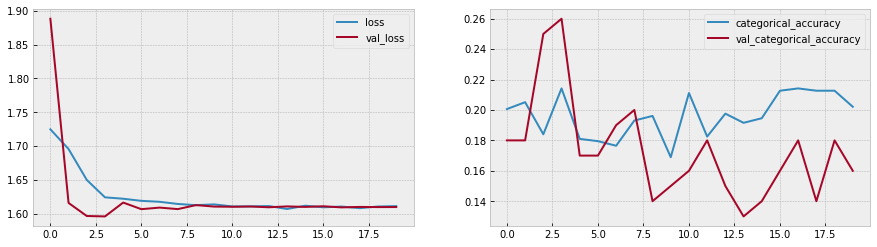

In [45]:
%%time
tranf_learning = RNN_CNN_TL2()
tranf_learning.init_imageparams(image_height=120,image_width=120)
tranf_learning.init_hyperparams(frames_to_sample=16,batch_size=10,no_epochs=20)
tranf_learning_model = tranf_learning.model_det(gru_cells=128, dense_neurons=128, drop_out=0.25)
tranf_learning_model.summary()
history_tranf_learning_model = tranf_learning.model_train(tranf_learning_model)

plot_model_history(history_tranf_learning_model)

**Observation:** We are getting a validation accuracy of 16% compared to tarining accuracy of 20.21%
- Total number of parameters are 8,381,950. 
- We can clearly see this model is no use. so we will end here.

# Here are all the models with their respective accuracy and number of parameters

| Model No. | Model Type      | No. parameters | Valadation Acc(%) | Tranning Acc(%) | Input Parameter                                                                                          |
| --------- | --------------- | -------------- | ----------------- | --------------- | -------------------------------------------------------------------------------------------------------- |
| 0         | 3D CNN          | 9,00,805       | 19                | 88.84           | HxW 120, frame=30,  batch\_size=55, epoch=20                                                             |
| 1         | 3D CNN          | 19,67,813      | 22                | 74.81           | HxW 120, frame=30,  batch\_size=55, epoch=20                                                             |
| 2         | 3D CNN          | 19,67,813      | 21                | 92.91           | HxW 120, frame=30,  batch\_size=55, epoch=15, dropout=0.5                                                |
| 3         | 3D CNN          | 17,62,613      | 68                | 83.26           | HxW 120, frame=30,  batch\_size=55, epoch=25, dropout=0.5, filter=2                                      |
| 4         | 3D CNN          | 25,56,533      | 73                | 91.86           | HxW 120, frame=20,  batch\_size=30, epoch=25,  filter=3, dense\_neurons=256                              |
| 5         | 3D CNN          | 25,56,533      | 21                | 48.72           | HxW 120, frame=20,  batch\_size=30, epoch=25, dropout=0.5, filter=3, dense\_neurons=256                  |
| 5.1       | 3D CNN          | 25,56,533      | 25                | 85.67           | HxW 120, frame=20,  batch\_size=30, epoch=25, dropout=0.25, filter=3, dense\_neurons=256                 |
| 6         | 3D CNN          | 9,08,645       | 74                | 88.99           | HxW 120, frame=16,  batch\_size=20, epoch=20, dropout=0.25, filter=2, dense\_neurons=128                 |
| 7         | 3D CNN          | 4,94,981       | 74                | 82.35           | HxW 120, frame=16,  batch\_size=20, epoch=20, dropout=0.25, filter=2, dense\_neurons=64                  |
| 8         | CNN-LSTM        | 16,56,453      | 81                | 88.39            | HxW 120, frame=16,  batch\_size=20, epoch=25, dropout=0.25, filter=3, dense\_neurons=128, lstm\_cell=128 |
| 8.1       | CNN-GRU        | 1,346,405      | 75                 | 93.21             | HxW 120, frame=16,  batch\_size=20, epoch=25, dropout=0.25, filter=3, dense\_neurons=128, GRU\_cell=128  |
| 9         | 3D CNN          | 19,66,309      | 79                | 71.87           | HxW 120, frame=20,  batch\_size=20, epoch=25, dropout=0.5, filter=3, dense\_neurons=256                  |
| 10        | 3D CNN          | 17,61,109      | 48                | 68.7            | HxW 120, frame=16,  batch\_size=30, epoch=25, dropout=0.5, filter=2, dense\_neurons=256                  |
| 11        | 3D CNN          | 25,54,549      | 83                | 70.21           | HxW 120, frame=16,  batch\_size=20, epoch=25, dropout=0.5, filter=2, dense\_neurons=256                  |
| 12        | 3D CNN          | 25,54,549      | 78                | 92.76           | HxW 120, frame=16,  batch\_size=20, epoch=25, dropout=0.25, filter=2, dense\_neurons=256                 |
| 13        | 3D CNN          | 9,09,637       | 88                | 92.38           | HxW 120, frame=30,  batch\_size=20, epoch=25, dropout=0.25, filter=3,2, dense\_neurons=128               |
| 13.1      | 3D CNN          | 9,07,733       | 85                | 91.1            | HxW 120, frame=16,  batch\_size=20, epoch=35, dropout=0.25, filter=2, dense\_neurons=128                 |
| **13.2**      | **3D CNN**          | **9,09,637**       | **94**                | **91.7**            | **HxW 120, frame=16,  batch\_size=20, epoch=35, dropout=0.25, filter=3,2, dense\_neurons=128**               |
| 13.3      | 3D CNN          | 9,09,637       | 66                | 93.06           | HxW 120, frame=16,  batch\_size=32, epoch=35, dropout=0.25, filter=3,2, dense\_neurons=128               |
| 14        | 3D CNN          | 4,94,245.00    | 81                | 85.9            | HxW 120, frame=16,  batch\_size=20, epoch=25, dropout=0.25, filter=2, dense\_neurons=64                  |
| 15        | CNN-GRU         | 25,57,413      | 82                | 99.55           | HxW 120, frame=16,  batch\_size=20, epoch=25, dropout=0.25, filter=3, dense\_neurons=128, GRU\_cell=128  |
| 15.1      | CNN-LSTM        | 33,76,357      | 78                | 99.4            | HxW 120, frame=16,  batch\_size=20, epoch=25, dropout=0.25, filter=3, dense\_neurons=128, LSTM\_cell=128 |
| 16        | TL-LSTM         |  3,840,453     | 72                | 99.55           | HxW 120, frame=16,  batch\_size=10, epoch=20, dropout=0.25, filter=3, dense\_neurons=128, LSTM\_cell=128 |
| 16.1      | TL-LSTM         | 35,16,229      | 77                | 99.1            | HxW 120, frame=16,  batch\_size=10, epoch=20, dropout=0.25, filter=3, dense\_neurons=64, LSTM\_cell=64   |
| 17        | TL-GRU          | 36,93,253      | 74                | 99.85           | HxW 120, frame=16,  batch\_size=10, epoch=20, dropout=0.25, filter=3, dense\_neurons=128, GRU\_cell=128  |
| 18        | TL-GRU          | 34,46,725      | 70                | 99.4            | HxW 120, frame=16,  batch\_size=10, epoch=20, dropout=0.25, filter=3, dense\_neurons=64, GRU\_cell=64    |
| 19        | TL-GRU-Non\_AUG |  3,446,725     | 71                | 99.25           | HxW 120, frame=16,  batch\_size=10, epoch=20, dropout=0.25, filter=3, dense\_neurons=64, GRU\_cell=64    |
| 20        | TL-GRU-B2       | 83,81,950      | 16                | 20              | HxW 120, frame=16,  batch\_size=10, epoch=20, dropout=0.25, filter=3, dense\_neurons=128, GRU\_cell=128  |

### So, here we have concluded that Model no 13.2 gave the best accuracy score both for Validation(94%) and training (91.7%)

# ----------------------------- Till here -----------------------------